# CS 506 Property Value Modeling Project
Team Massachusetts: Qingyang Xu, Kailun Li, Ziyu Shen, Chenhao Tao


In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
#%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import statistics


# Helper functions for data cleaning, ploting, and training

In [143]:
def dataClean(xcols_fc):
    df = pd.read_csv("pc_MA_GE508.csv")
    #Calculate new variables we need
    df['p_f_change'] = df['p_f_2010'] - df['p_f_1990']
    df['ls_price_per_ha'] = df['ls_price'] / df['ha']
    df['ls_price_per_ha_log'] = np.log(df['ls_price_per_ha'])
    df['ls_year'] = pd.to_datetime(df['ls_date']).dt.year
    df['p_e_ls'] = np.where(df['e_year'].le(df['ls_year']), df['p_e'], 0)

    #drop nan in ls_price
    df = df[pd.notnull(df['ls_price'])]
    df['ls_price'] = pd.to_numeric(df['ls_price'])

    #set range of price
    df = df[(df['ls_price']>10000)&(df['ls_price']<1000000)]

    #drop nan in ls_year
    df_drop_null_predict = df.dropna(subset = xcols_fc)
    df_drop_null_predict = df_drop_null_predict.dropna(subset = ["ls_year"])

    #set range of year
    df_drop_null_predict = df_drop_null_predict[df_drop_null_predict['ls_year'] >= 2000]
    df_drop_null_predict = df_drop_null_predict[df_drop_null_predict['ls_year'] <= 2017]

    df_drop_null_predict.to_csv('clean.csv',index = False)
    return df_drop_null_predict

#k fold cross validation RandomForest Regressor
def trainRFwithKFold(k,X_ls,y_ls):
    test_size = 1/k
    models = []
    MAEs = []
    y = np.array(y_ls)
    X = np.array(X_ls)
    length = len(y)
    idx_step = math.floor(test_size*length)
    for i in range(0,k):
        idx_start = i*idx_step
        idx_end = (i+1)*idx_step-1
        X_test = X[idx_start:idx_end,:]
        y_test = y[idx_start:idx_end]
        X_train1 = X[np.arange(0,idx_start)]
        X_train2 = X[np.arange(idx_end,length)]
        y_train1 = y[np.arange(0,idx_start)]
        y_train2 = y[np.arange(idx_end,length)]
        X_train = np.concatenate((X_train1,X_train2),axis = 0)
        y_train = np.concatenate((y_train1,y_train2),axis = 0)
        rf_model = RandomForestRegressor(n_estimators = 100, max_depth = 11)
        rf_model.fit(X_train, y_train)
        mae = mean_absolute_error(y_test, rf_model.predict(X_test))
        print(mae)
        MAEs.append(mae)
        models.append(rf_model)

        #plot
        plotScatter(rf_model,X_train,X_test,y_train, y_test,i)
    print("MAE for each model", MAEs)
    print("Average MAE", statistics.mean(MAEs))

    return models,MAEs

#scatter plot helper function
def plotScatter(rf_model,X_train,X_test,y_train,y_test,k):
    fig, ax = plt.subplots(figsize=(10,10))
    y_train_predict = rf_model.predict(X_train)
    y_test_predict = rf_model.predict(X_test)
    ax.scatter(y_train, y_train_predict, c='m', s=3, label='train set')
    ax.scatter(y_test,y_test_predict, c='b',s=3, label='test set')
    ax.grid(True)
    ax.set_title("Training Set and Test Set", fontsize=14)
    ax.set_xlabel("True Target", fontsize=12)
    ax.set_ylabel("Prediction", fontsize=12)
    ax.legend()
    plt.savefig(str(k+1)+".png")
    plt.show()

def loadData(filename):
    df = pd.read_csv(filename)
    return df




# Data Preprocessing and Preparation 

In [137]:

#Choose Features we want for regression
xcols_fc = ['slope', 'travel', 'p_f_2000', 'p_prot_1990_500', 'p_wet', 'coast_2500', 'lake_frontage', 'river_frontage', 'pop_dens_tract_2012-2016', 'hh_inc_avg_tract_2012-2016']
xcols_ls = xcols_fc + ['bld_area', 'ls_year']
#-------------------------------------------
#Datacleaning
df_drop_null_predict = dataClean(xcols_fc)
#df_drop_null_predict = loadData('clean.csv')


#Choose land data without easement, prepare for model training
df2 = df_drop_null_predict[(df_drop_null_predict['e_year'].isnull())]
df3 = df_drop_null_predict[(df_drop_null_predict['ls_year'] < df_drop_null_predict['e_year'])]
df_new = df2.append(df3)
#log transform price to log price
df_new['log_price'] = np.log(df_new['ls_price'])

#Extract land data with easement, prepare for model prediction
df_easement_dataset = df_drop_null_predict[df_drop_null_predict['e_year'].notnull()]
df_easement_dataset = df_easement_dataset[(df_easement_dataset['ls_year'] > df_easement_dataset['e_year'])]
df_easement_dataset['log_price'] = np.log(df_easement_dataset['ls_price'])
df_easement_without_price_for_testing = df_easement_dataset[xcols_ls]
df_easement_logprice = df_easement_dataset['log_price']

#Generate training set which are land information and land sale price
X_ls = df_new[xcols_ls]
y_ls = df_new['log_price']


/Users/kailunli/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


# Model Tuning

/Users/kailunli/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kailunli/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kailunli/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kailunli/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kailunli/

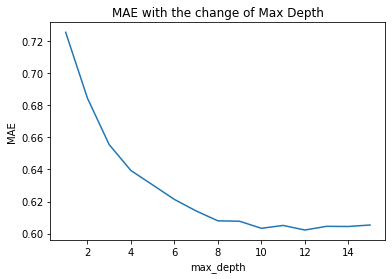

In [138]:
#tuning max_depth
X_train, X_test, y_train, y_test = train_test_split(X_ls, y_ls)
max_depth = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
MAE_depth = []
for i in max_depth:
    rf_model = RandomForestRegressor(max_depth = i)
    rf_model.fit(X_train, y_train)
    mae = mean_absolute_error(y_test, rf_model.predict(X_test))
    MAE_depth.append(mae)
MAE_depth
plt.plot(max_depth, MAE_depth) 
  
# naming the x axis 
plt.xlabel('max_depth') 
# naming the y axis 
plt.ylabel('MAE') 
  
# giving a title to my graph 
plt.title('MAE with the change of Max Depth') 
  
# function to show the plot 
plt.show() 


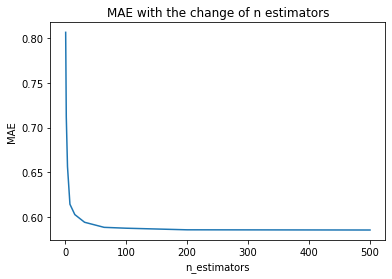

[0.8066702382273514, 0.7121151832507907, 0.6561908761350214, 0.6140956344993869, 0.6025105282332156, 0.5939084841775005, 0.5882256086122153, 0.5872552487153694, 0.5854614189277556, 0.5852337665785854]


In [139]:
#tuning n_estimators
n_estimator = [1, 2, 4, 8, 16, 32, 64, 100, 200, 500]
MAE_estimator = []
for i in n_estimator:
    rf_model = RandomForestRegressor(n_estimators = i)
    rf_model.fit(X_train, y_train)
    mae = mean_absolute_error(y_test, rf_model.predict(X_test))
    MAE_estimator.append(mae)
plt.plot(n_estimator, MAE_estimator) 
  
# naming the x axis 
plt.xlabel('n_estimators') 
# naming the y axis 
plt.ylabel('MAE') 
  
# giving a title to my graph 
plt.title('MAE with the change of n estimators') 

# function to show the plot 
plt.show() 
print(MAE_estimator)

# Modeling

0.5794258802789983


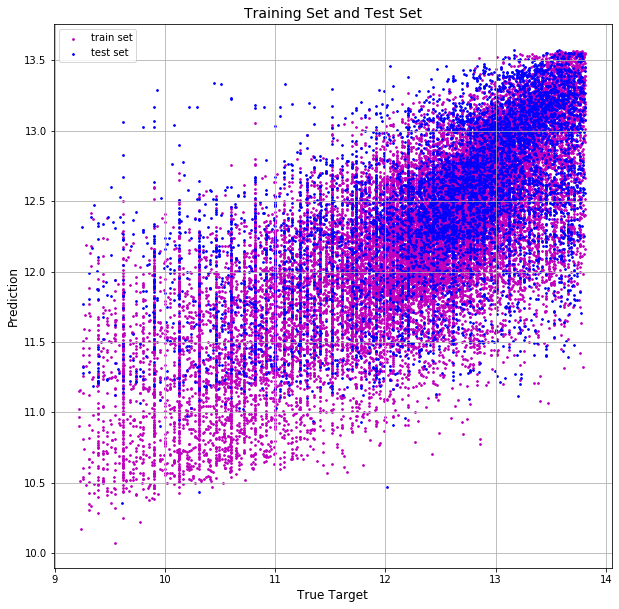

MAE for each model [0.5794258802789983]
Average MAE 0.5794258802789983
0.5607734177371924


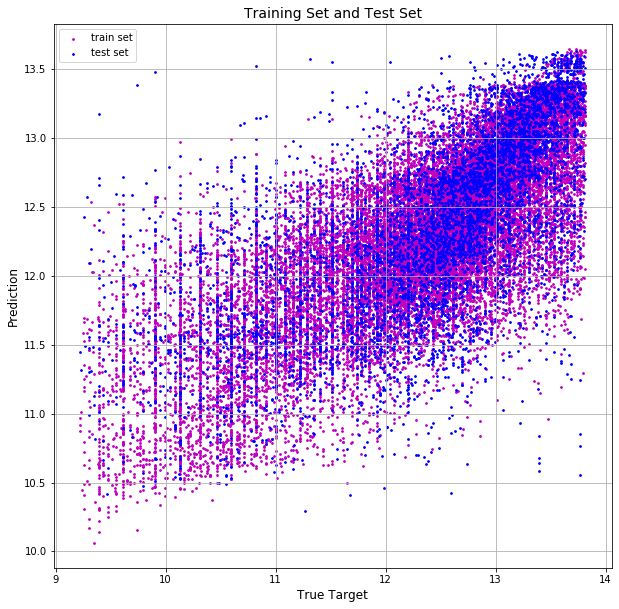

MAE for each model [0.5794258802789983, 0.5607734177371924]
Average MAE 0.5700996490080954
0.6294071014700215


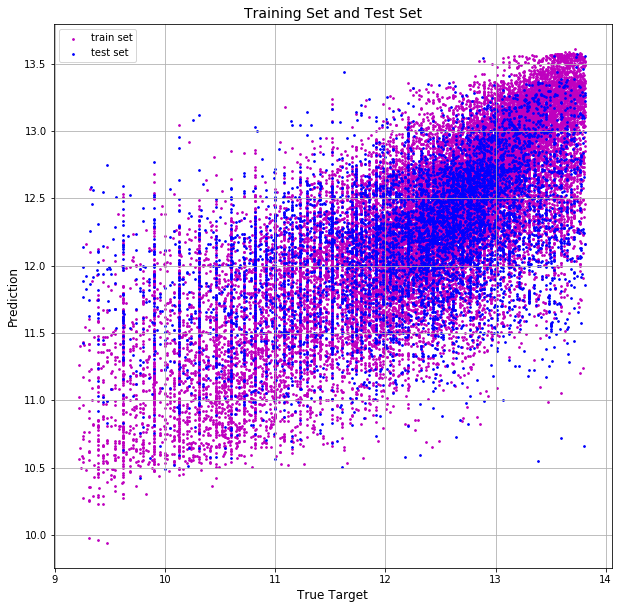

MAE for each model [0.5794258802789983, 0.5607734177371924, 0.6294071014700215]
Average MAE 0.5898687998287374
0.5595328702319659


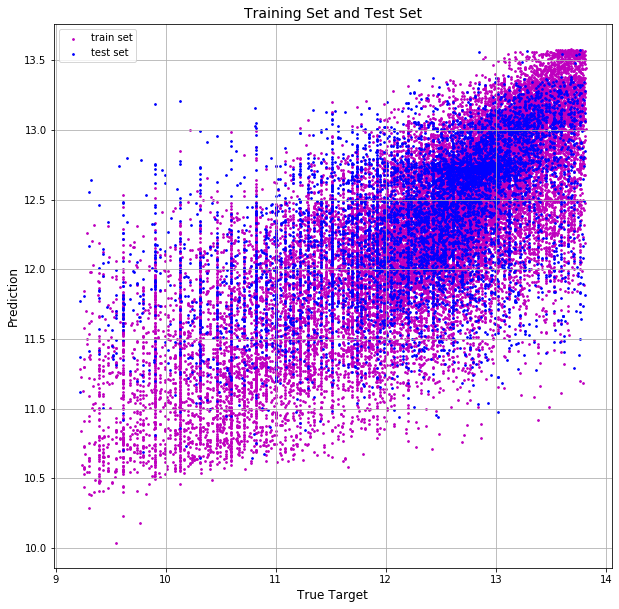

MAE for each model [0.5794258802789983, 0.5607734177371924, 0.6294071014700215, 0.5595328702319659]
Average MAE 0.5822848174295445
0.7715902045823069


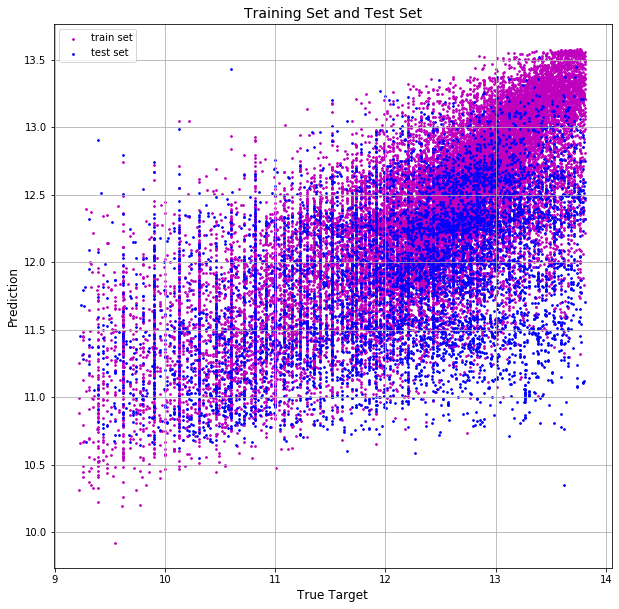

MAE for each model [0.5794258802789983, 0.5607734177371924, 0.6294071014700215, 0.5595328702319659, 0.7715902045823069]
Average MAE 0.620145894860097


In [140]:

#Train with kfold, get the list of MAE and list of models
rf_models, MAEs = trainRFwithKFold(5,X_ls,y_ls)

#Chooses the model with the lowest MAE as our primary predictive model
n = MAEs.index(min(MAEs))
#Estimate land price for lands with easement use the primary predictive model we choose
rf_estimate_easement_price = rf_models[n].predict(df_easement_without_price_for_testing)




#Calculate the percentage difference between estimated price and real price
diff = ((np.exp(rf_estimate_easement_price) - np.exp(df_easement_logprice))/ np.exp(df_easement_logprice) ).mean()

# Result

In [141]:
print("percentage difference showing the impact the easement", diff)

percentage difference showing the impact the easement 0.39021957822691666


No handles with labels found to put in legend.


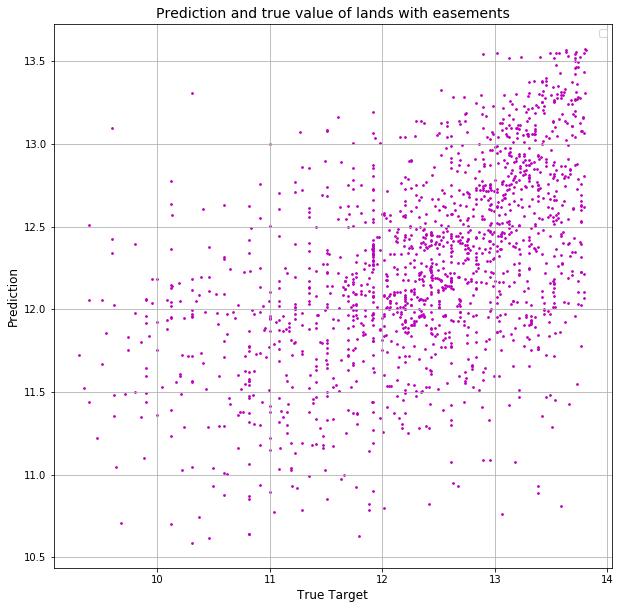

In [142]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df_easement_logprice, rf_estimate_easement_price, c='m', s=3)
ax.grid(True)
ax.set_title("Prediction and true value of lands with easements", fontsize=14)
ax.set_xlabel("True Target", fontsize=12)
ax.set_ylabel("Prediction", fontsize=12)
ax.legend()
plt.savefig("easement_result.png")
plt.show()